# 1. Imports

In [114]:
import warnings
import inflection

import pandas     as pd
import seaborn    as sns
import numpy      as np
import scikitplot as skplt

from IPython.core.display    import HTML
from IPython.display         import Image

from boruta                  import BorutaPy
from matplotlib              import pyplot   as plt

from imblearn.over_sampling  import SMOTE, SMOTENC
from imblearn.combine        import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics         import roc_auc_score, roc_curve, plot_confusion_matrix, log_loss
from sklearn.base            import clone

from xgboost                 import XGBClassifier

## 1.1. Helper Functions

### 1.1.1. General

In [5]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("whitegrid")
    sns.set_palette("muted")

    warnings.filterwarnings('ignore')

### 1.1.2. Metrics

In [6]:
def ml_metrics(model_name, y, y_pred):
    
    acc     = accuracy_score( y, y_pred ) 
    prec    = precision_score( y, y_pred )
    rec     = recall_score( y, y_pred )
    f1score = f1_score( y, y_pred )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'Accuracy'  : acc,
                           'Recall'    : rec,
                           'F1 Score'  : f1score }, index=[0] )


def get_lift_gain(model, X, y, step=0.1):
    
    lift_list = []
    gain_list = [0]
    
    y_pred_proba = model.predict_proba(X)[:,1]
    df_y = pd.DataFrame({"y":y.values, "y_proba":y_pred_proba}).sort_values( by='y_proba', ascending=False )
    
    sample_axis = np.arange( step, step+1, step )
    total_numb_of_samples = df_y.shape[0]
    total_numb_of_positives = df_y['y'].sum()
    total_positive_ratio = total_numb_of_positives / total_numb_of_samples
    
    for sample_pct in sample_axis:
        numb_of_samples = int(np.ceil(sample_pct*total_numb_of_samples))
        df_aux = df_y.iloc[ :numb_of_samples, : ]
        
        numb_of_positives = df_aux['y'].sum()
        positive_ratio = numb_of_positives / numb_of_samples
        
        lift_list.append( positive_ratio / total_positive_ratio )
        gain_list.append( numb_of_positives / total_numb_of_positives )
    
    return lift_list, gain_list 


def cross_val(X, y, model_name, model, kfold=10):
    
    mod = clone(model)
    
    acc_list = []
    recall_list = []
    f1score_list = []
    
    skf = StratifiedKFold(n_splits=kfold)
    
    for train_index, test_index in skf.split(X, y):
        # split dataset
        x_training = X.iloc[ train_index, : ]
        y_training = y[ train_index ]
        
        x_testing = X.iloc[ test_index, : ]
        y_testing = y[ test_index ]
            
        # transform data
        ss_balance = StandardScaler()
        ss_age = StandardScaler()
        
        ms_tenure = MinMaxScaler()
        ms_estSalary = MinMaxScaler()
        
        rs_creditScore = RobustScaler()
        rs_NumOfProducts = RobustScaler()
        
        Gender_dict = {'Male': 0, 'Female': 1}
        
        # fit and transform training data
        x_training['balance'] = ss_balance.fit_transform( x_training[['balance']].values )
        x_training['age'] = ss_age.fit_transform( x_training[['age']].values )
        x_training['tenure'] = ms_tenure.fit_transform( x_training[['tenure']].values )
        x_training['estimated_salary'] = ms_estSalary.fit_transform( x_training[['estimated_salary']].values )
        x_training['credit_score'] = rs_creditScore.fit_transform( x_training[['credit_score']].values )
        x_training['num_of_products'] = rs_NumOfProducts.fit_transform( x_training[['num_of_products']].values )
        x_training = pd.get_dummies(x_training, prefix=['geography'], columns=['geography'] )
        x_training['gender'] = x_training['gender'].map(Gender_dict)
        
        # transform test data
        x_testing['tenure'] = ms_tenure.transform( x_testing[['tenure']].values )
        x_testing['balance'] = ss_balance.transform( x_testing[['balance']].values )
        x_testing['estimated_salary'] = ms_estSalary.transform( x_testing[['estimated_salary']].values )
        x_testing['age'] = ss_age.transform( x_testing[['age']].values )
        x_testing['credit_score'] = rs_creditScore.transform( x_testing[['credit_score']].values )
        x_testing['num_of_products'] = rs_NumOfProducts.transform( x_testing[['num_of_products']].values )
        x_testing['gender'] = x_testing['gender'].map(Gender_dict)
        x_testing = pd.get_dummies(x_testing, prefix=['geography'], columns=['geography'] )
       
        # sampling
        sample_method = SMOTETomek( smote=SMOTENC(categorical_features=[1, 5, 6, 7, 9, 10, 11]), tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
        X_train_bal, y_train_bal = sample_method.fit_sample(x_training, y_training)
        
        # model
        mod = mod.fit( X_train_bal, y_train_bal )

        # prediction
        yhat = mod.predict( x_testing ) 
        
        # performance
        m_result = ml_metrics( model_name, y_testing, yhat )

        # store performance of each kfold iteration
        acc_list.append( m_result['Accuracy'] )
        recall_list.append( m_result['Recall'] )
        f1score_list.append( m_result['F1 Score'] )
  
    return pd.DataFrame( 
        {'Model Name': model_name,
        'Accuracy CV': np.round( np.mean( acc_list ), 2 ).astype( str ) + " +/- " + np.round( np.std( acc_list ), 2 ).astype( str ),
        'Recall CV': np.round( np.mean( recall_list ), 2 ).astype( str ) + " +/- " + np.round( np.std( recall_list ), 2 ).astype( str ), 
        'F1 Score CV': np.round( np.mean( f1score_list ), 2 ).astype( str ) + " +/- " + np.round( np.std( f1score_list ), 2 ).astype( str ) }, index=[0] )    

### 1.1.2. For Plot

In [7]:
def plot_histogram(df, cols, normalized=False):
    mask = df['exited'] == 1
    
    if len(cols) <= 3:
        n_rows = 1
        n_cols = len(cols)
    else:
        n_rows = int(np.ceil(len(cols)/3))
        n_cols = 3
    
    fig, axes = plt.subplots(n_rows, n_cols)
    for ax_i, col in zip(axes.ravel(), cols):
        ax_i.hist( df5[mask][col] , histtype='step', density=normalized, label='Churn'     , linewidth=2 )
        ax_i.hist( df5[~mask][col], histtype='step', density=normalized, label='Not Churn' , linewidth=2 )
        ax_i.set_xlabel(col)
        ax_i.legend()
    
    return None
    
    
def get_colors():
    return ['blue', 'black', 'green', 'purple', 'yellow', 'red']


def plot_cumulative_gain(ax, gains, models, churn_ratio=0.2, step=0.1):
    ax.plot([0, churn_ratio, 1], [0, 1, 1], 'r--', linewidth=2, label='Ideal Classifier')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    
    colors = get_colors()
    
    for gain, model, color in zip(gains, models, colors):    
        ax.plot(np.arange(0, 1. + step, step), gain, linewidth=2, color=color, label=model)

    ax.set_title(f'Cumulative Gains')
    ax.set_xlabel(f'Percentage of Sample')
    ax.set_ylabel('Percentage of Churned Customers')
    ax.legend(loc='lower right')

    ticks = np.arange(0., 1.2, .2)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0, 1.)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)
    
    return None


def plot_lift_curve(ax, lifts, models, step):
    x = np.arange(step, step + 1, step)
    
    colors = get_colors()
    
    ax.plot(x, np.ones(len(x)), 'k--', label='Baseline')
    for lift, model, color in zip(lifts, models, colors):
        ax.plot(x, lift, '-', color=color, linewidth=3, markersize=5, label=model)
    ax.set_xlabel('Percentage of Sample')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    
    ticks = np.arange(0, 1.1, .1)
    ax.set_xticks(ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.legend(loc='best')
        
    ticks = np.arange(0.1, 1.1, .1)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0.1, 1.)
    
    lift_max = np.ceil(max(max(lifts)))
    ticks = np.arange(0, lift_max + 1, 1)
    ax.set_yticks(ticks=ticks, minor=False)
    ticks = np.arange(0.5, lift_max, .5)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_ylim(0, lift_max + .5)
    
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.1)
    
    return ax

def plot_lift_gain_curves(gains, lifts, models, churn_ratio=0.2, step=0.1):
    fig, axes = plt.subplots(1,2)
    plot_cumulative_gain(axes[0], gains, models, step=0.1)
    plot_lift_curve(axes[1], lifts, models, step=0.1)
    
    return None

def plot_separation(model, X, y, name):
    y_pred_proba = model.predict_proba( X )[:,1]

    fig, ax = plt.subplots(1,2)

    ax[0].hist( y_pred_proba[y.astype(bool)], histtype='step', density=False, label='Churn', linewidth=2 )
    ax[0].hist( y_pred_proba[~y.astype(bool)], histtype='step', density=False, label='Not Churn', linewidth=2 )
    ax[0].set_title( '{} Separation'.format( name ) )
    ax[0].set_xlabel( 'Churn Probability' )
    
    ax[1].hist( y_pred_proba[y.astype(bool)], histtype='step', density=False, label='Churn', linewidth=2, log=True )
    ax[1].hist( y_pred_proba[~y.astype(bool)], histtype='step', density=False, label='Not Churn', linewidth=2, log=True )
    ax[1].set_title( '{} Separation (log-scale)'.format( name ) )
    ax[1].set_xlabel( 'Churn Probability' )
    
    plt.legend()
    
    return None

## 1.2. Loading Data

In [8]:
jupyter_settings()

In [9]:
df1 = pd.read_csv( '../data/churn.csv' ).drop( columns='RowNumber' )
df1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2. Data Description

In [10]:
df2 = df1.copy()

## 2.1. Renaming Columns

In [11]:
cols_old = df2.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list( map(snake_case, cols_old) )

# rename columns
df2.columns = cols_new
df2.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 2.1. Data Dimensions

In [12]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 10000
Number of columns: 13


## 2.2. Data Types

In [13]:
df2.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 2.3. Check NA

In [14]:
df2.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 2.4. Fillout NA

## 2.5. Change Data Types

## 2.6. Descriptive Statistics

In [15]:
num_attrib = df2.select_dtypes( include=[int, float] )
cat_attrib = df2.select_dtypes( include=object )

### 2.6.1. Numerical Attributes

In [16]:
num_attrib.describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### 2.6.1. Categorical Attributes

In [17]:
# number of unique values
cat_attrib.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

# 3. Feature Engineering

In [18]:
df3 = df2.copy()

## 3.1. Mind Map

## 3.2. Creating Hypotheses

**1.** The older (Age) the customers, the more likely they are to churn.

**2.** The number of churned customers without a credit card is greater than the ones with credit card. 

**3.** The lower the credit score of the customers, the more likely they are to churn.

**5.** Customers with an estimated salary less than 50000 are more likely to churn.

**6.** Customers who spent less than the average are more likely to churn.

**7.** Customers who were active for less time are more likely to churn.

**8.** Customers who are not active members are more likely to churn.

**9.** Germans customers are more likely to churn.

**10.** Male customers are more likely to churn.

## 3.3. Creating New Features

# 4. Data Filtering

In [19]:
df4 = df3.copy()

# 5. EDA

In [20]:
df5 = df4.copy()

## 5.1. Univariate Analysis

### 5.1.1. Numerical Attributes

In [21]:
num_attrib.columns

Index(['customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

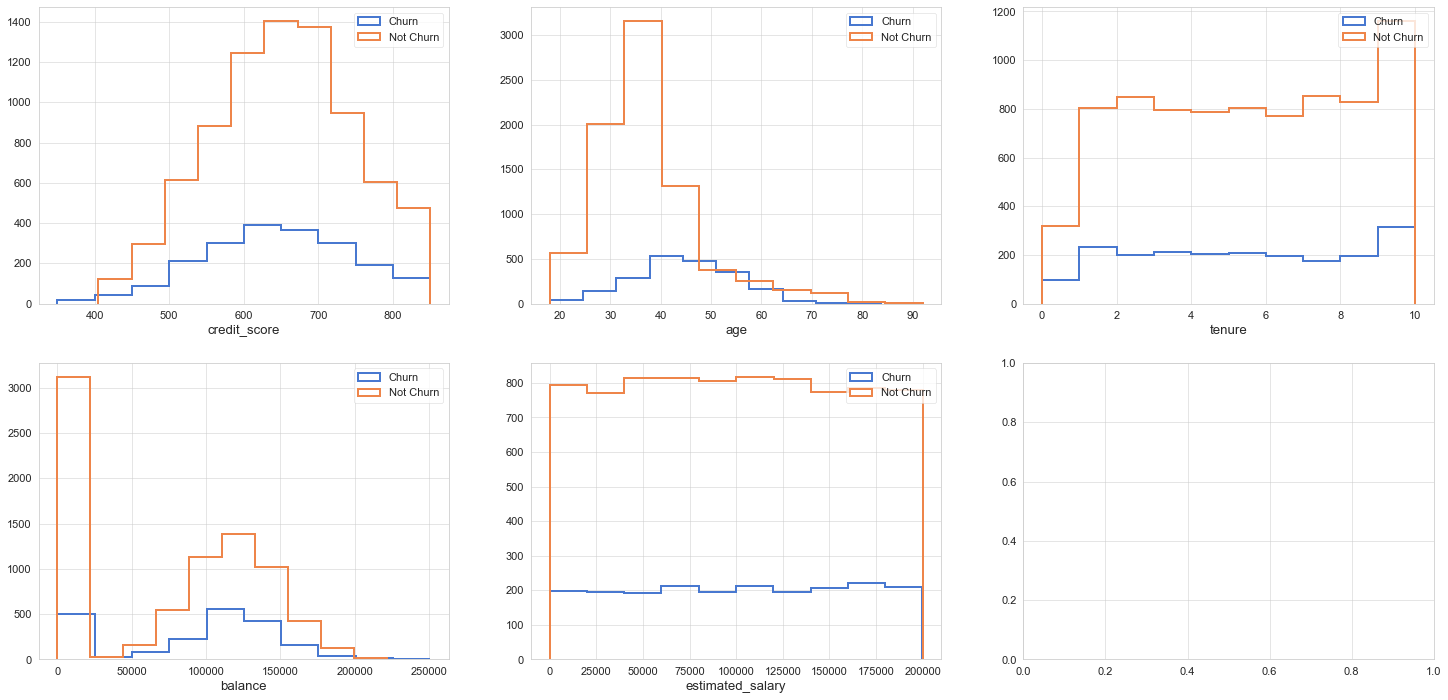

In [22]:
cols = ['credit_score', 'age', 'tenure', 'balance','estimated_salary']
plot_histogram(df5, cols)

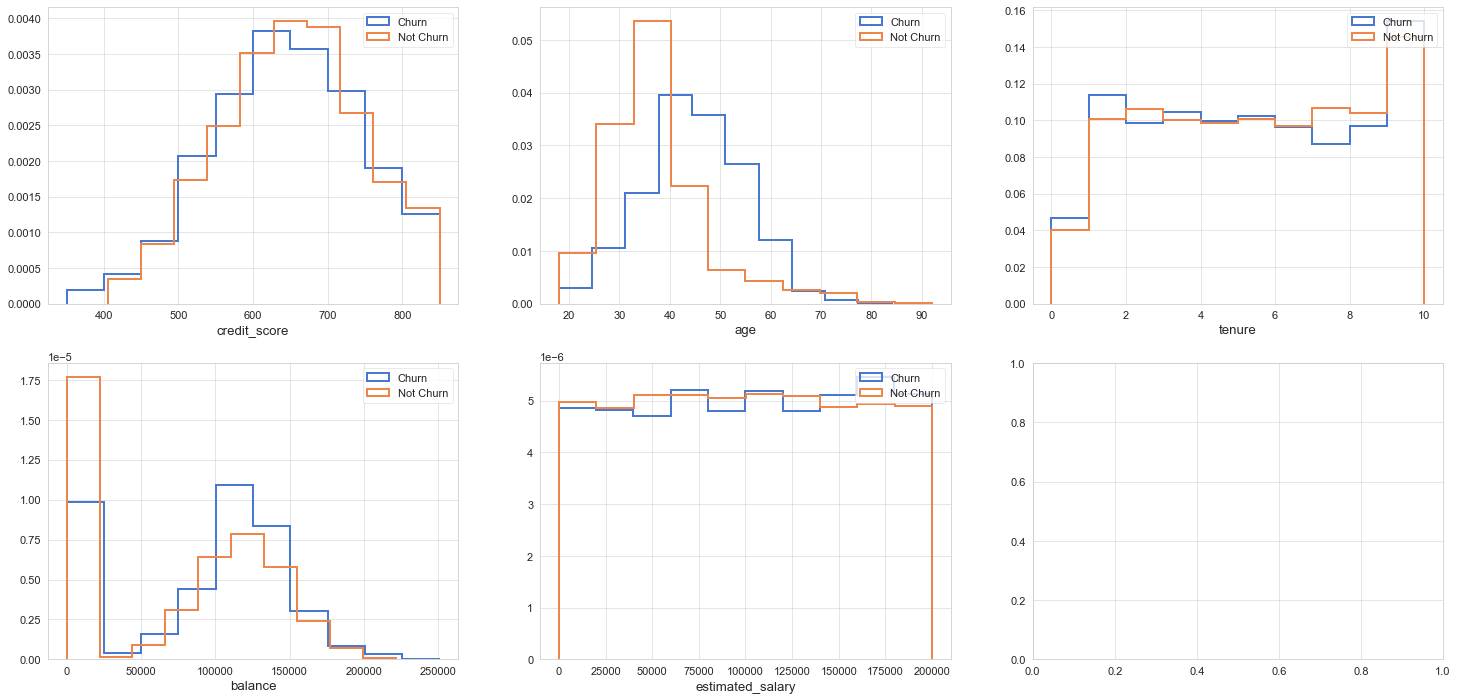

In [23]:
# plot normalized histograms
plot_histogram(df5, cols, normalized=True)

### 5.1.1. Categorical Attributes

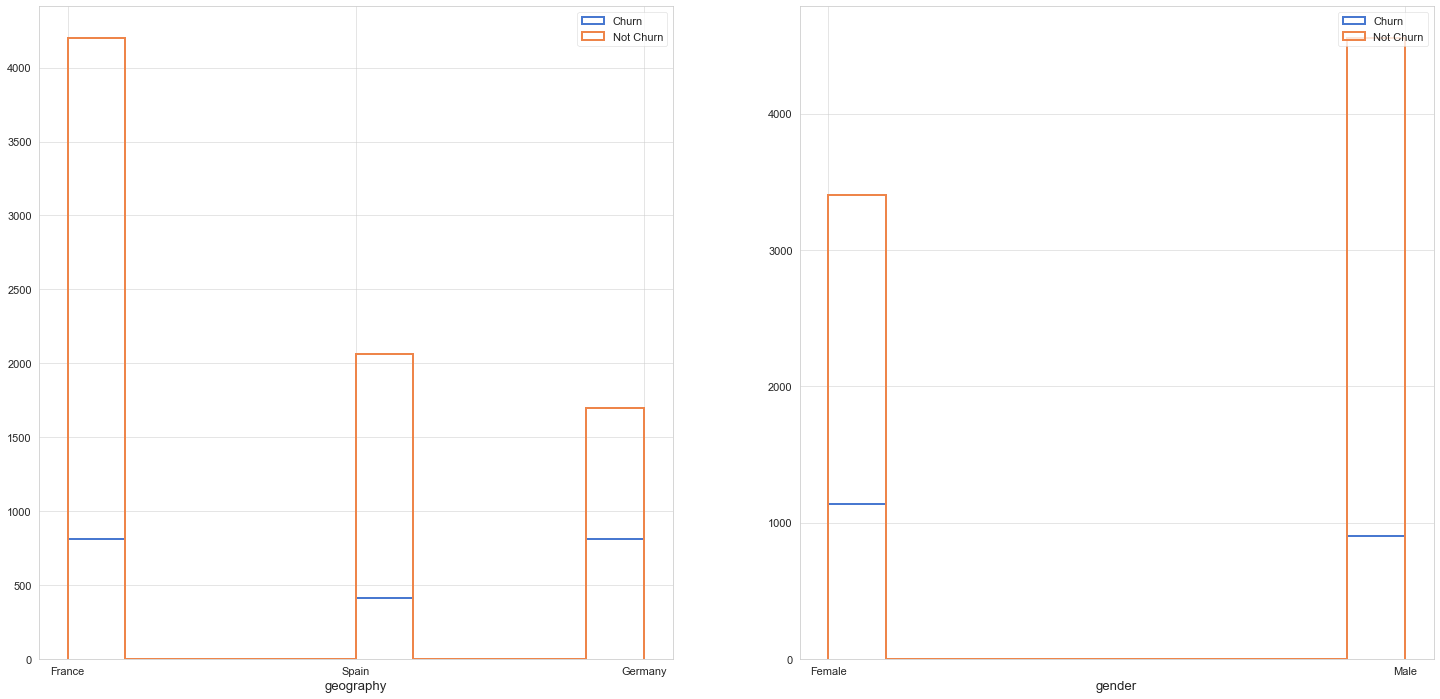

In [24]:
cols = ['geography', 'gender']
plot_histogram(df5, cols)

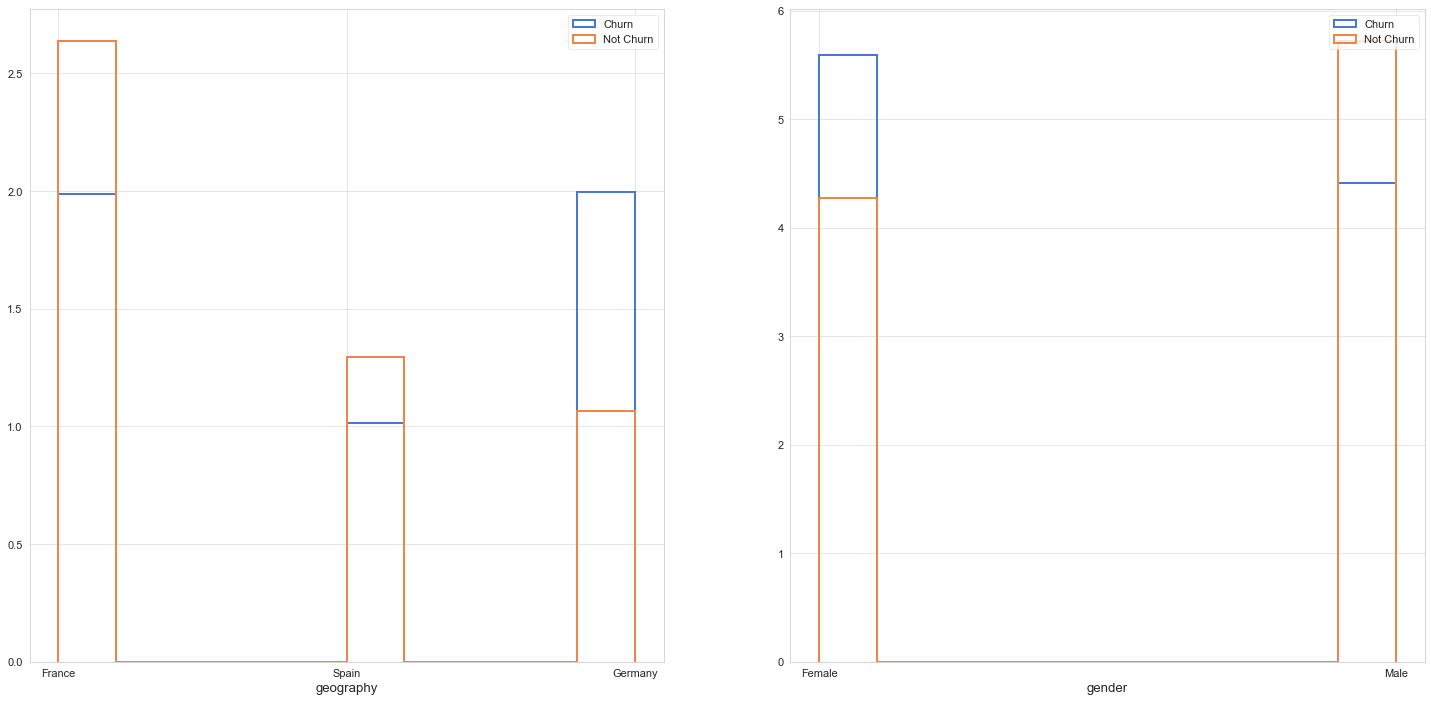

In [25]:
# plot normalized histograms
plot_histogram(df5, cols, True)

## 5.2. Bivariate Analysis 

### H1. The older (Age) the customers, the more likely they are to churn.
* **PARTIALLY TRUE** - Up to 50-56 years the statement is true, however after that the behavior inverts.

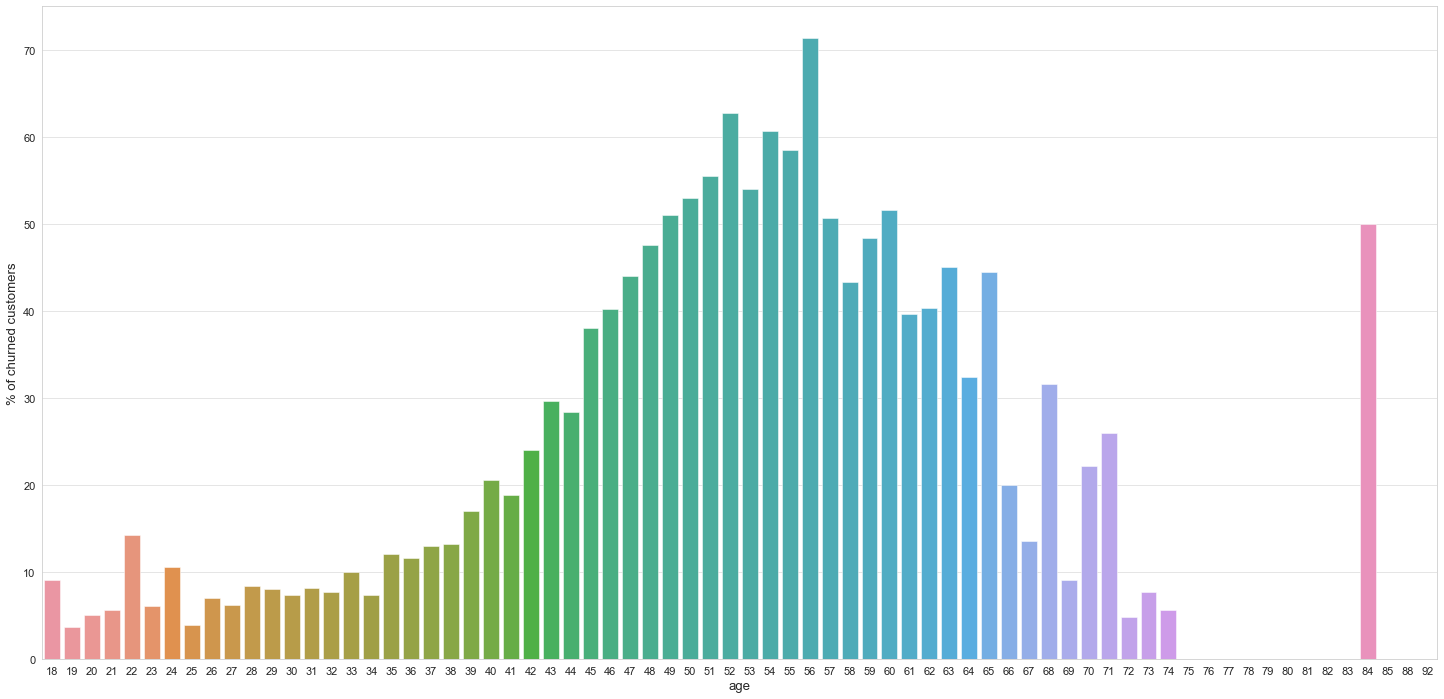

In [26]:
df_aux = df5[['age', 'exited']].groupby( 'age' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='age', y='% of churned customers', data=df_aux );

### H2. The number of churned customers without a credit card is greater than the ones with credit card. 
* **FALSE** - The number of churned customers without a credit card is **LOWER** than the ones with credit card. 

In [27]:
df_aux = df5[['has_cr_card', 'exited']].groupby( 'has_cr_card' ).agg({"exited":["mean", "sum"]})
df_aux.columns = ["Churn Rate", "Nº of customers"]
df_aux

,Churn Rate,Nº of customers
has_cr_card,,
0,0.208149,613
1,0.201843,1424


### H3. The lower the credit score of the customers, the more likely they are to churn.
* **PARTIALLY TRUE** - Up to 450 credit score the statment is true. Especially the customers with a credit score below 400, where the churn rate is 100%.

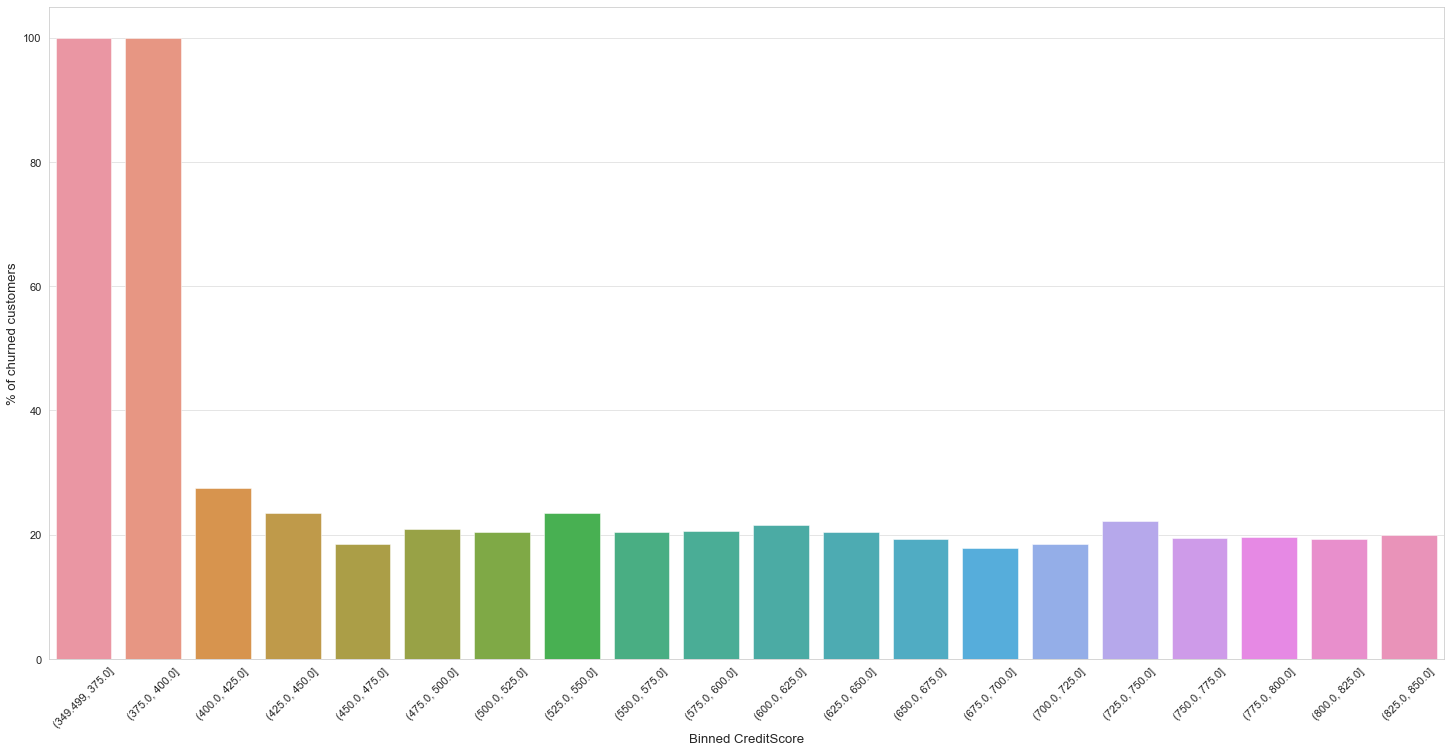

In [28]:
df_aux = df5.copy()
df_aux['Binned CreditScore'] = pd.cut(df_aux['credit_score'], bins=20, include_lowest=True)

df_aux = df_aux[['Binned CreditScore', 'exited']].groupby( 'Binned CreditScore' ).apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Binned CreditScore', y='% of churned customers', data=df_aux)
plt.xticks(rotation=45);

### H4. Customers who bought just one product are more likely to churn.
* **FALSE** - Customers who bought **four** products are more likely to churn.

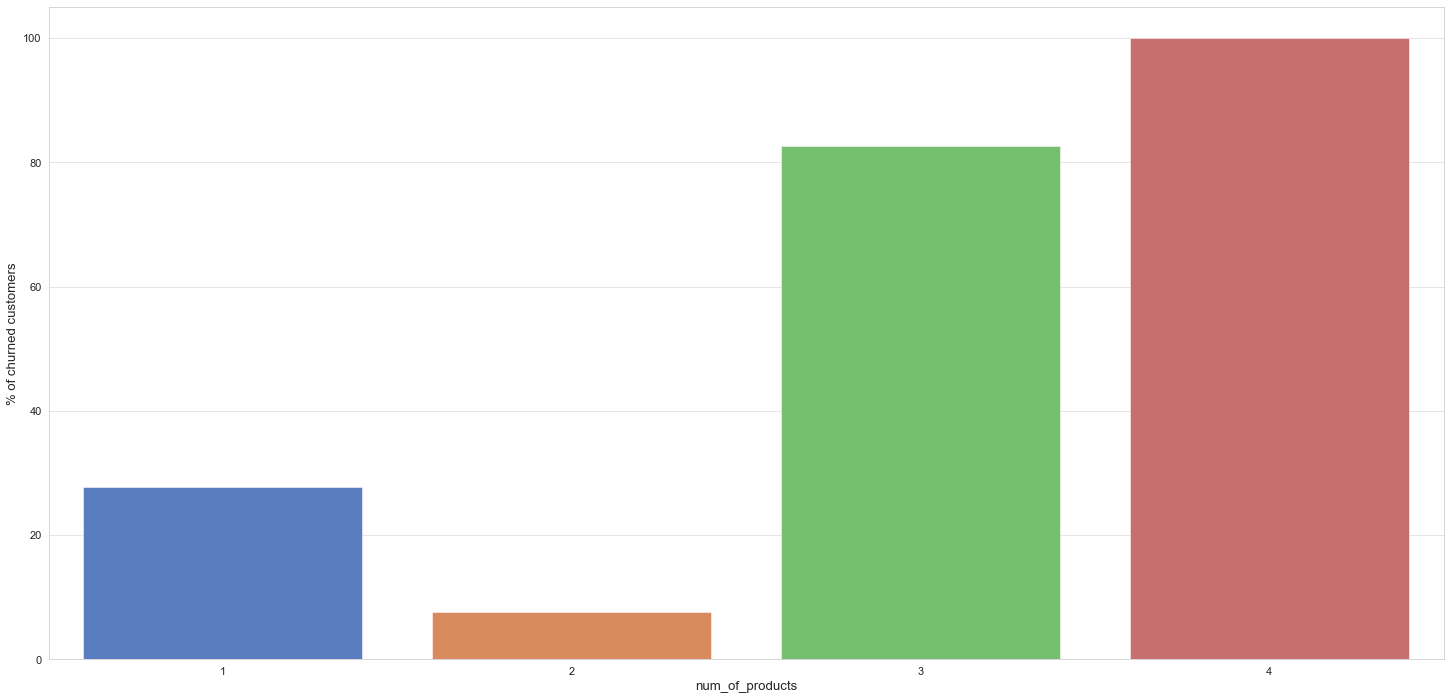

In [29]:
df_aux = df5[['num_of_products', 'exited']].groupby( 'num_of_products' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='num_of_products', y='% of churned customers', data=df_aux);

In [30]:
df5[['num_of_products', 'exited']].drop_duplicates()

,num_of_products,exited
0,1,1
1,1,0
2,3,1
3,2,0
5,2,1
7,4,1
482,3,0


### H5. Customers with an estimated salary less than 50000 are more likely to churn.
* **FALSE** - There is no direct correlation between salary and churn rate.

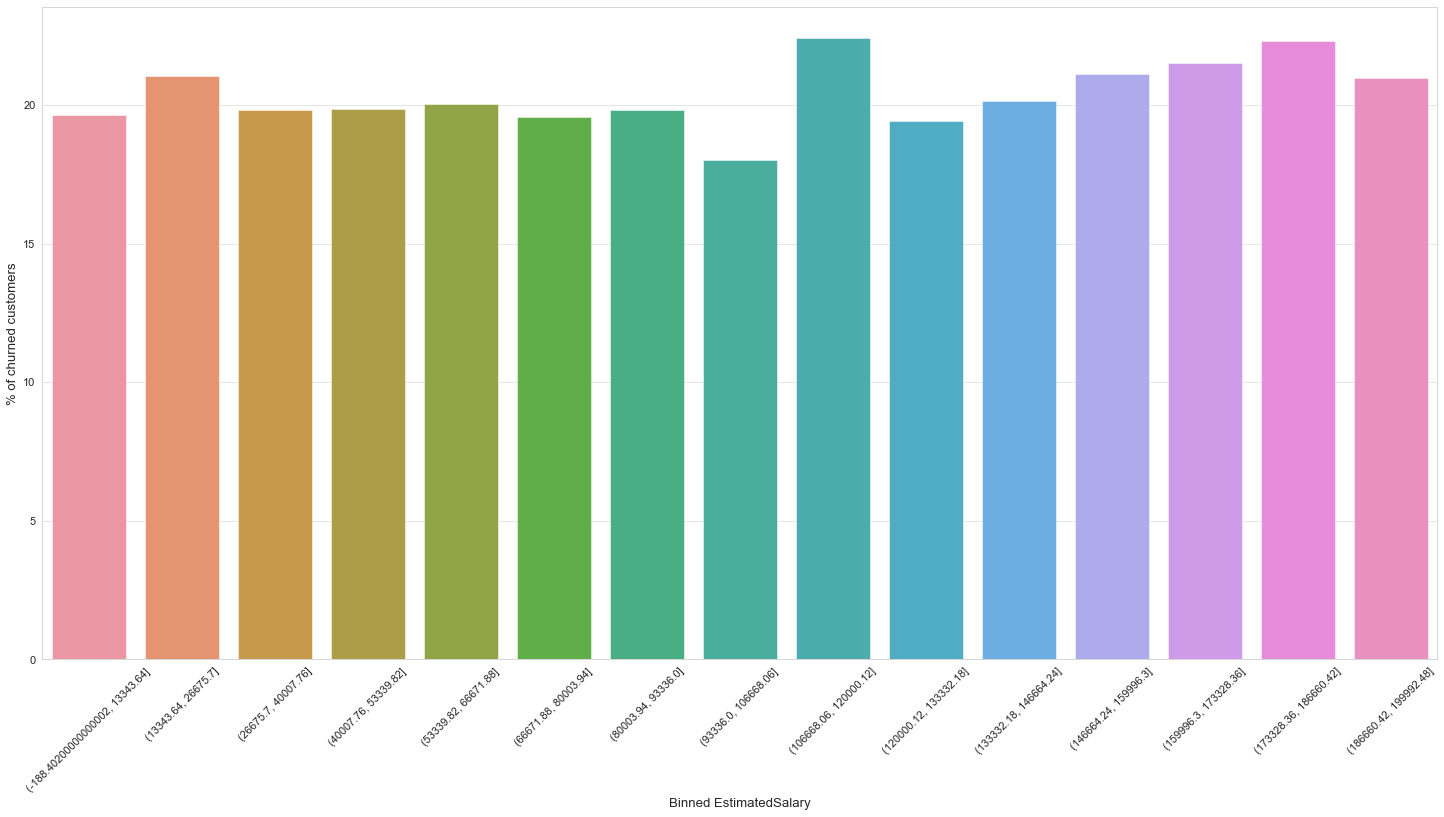

In [31]:
df_aux = df5.copy()
df_aux['Binned EstimatedSalary'] = pd.cut(df_aux['estimated_salary'], bins=15, include_lowest=True)

df_aux = df_aux[['Binned EstimatedSalary', 'exited']].groupby( 'Binned EstimatedSalary' ).apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='Binned EstimatedSalary', y='% of churned customers', data=df_aux)
plt.xticks(rotation=45);

### H6. Customers who spent less than the average are more likely to churn.
* **FALSE** - Customers who spent **more** than the average are more likely to churn.

In [32]:
df_aux = df5.copy()

balanceMean = df5['balance'].mean()
df_aux['Balance Range'] = df_aux['balance'].apply( lambda x: '<= mean' if x <= balanceMean else '> mean' )

df_aux = df_aux[['Balance Range', 'exited']].groupby( 'Balance Range' ).agg({"exited":["mean", "sum"]})
df_aux.columns = ["Churn Rate", "Nº of customers"]

df_aux

,Churn Rate,Nº of customers
Balance Range,,
<= mean,0.149718,611
> mean,0.240919,1426


### H7. Customers who were active for less time are more likely to churn.
* **FALSE** - There is no direct correlation between active time and churn rate.

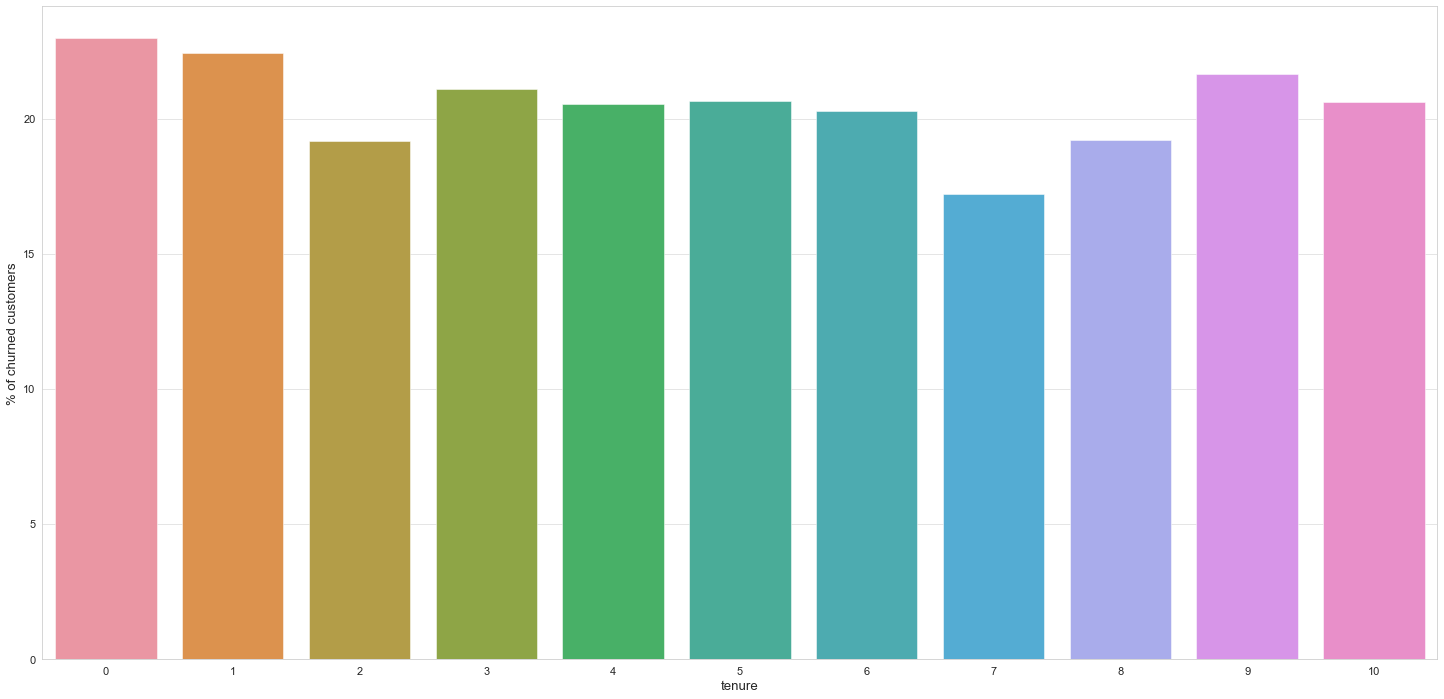

In [33]:
df_aux = df5[['tenure', 'exited']].groupby( 'tenure' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='tenure', y='% of churned customers', data=df_aux);

### H8. Customers who are not active members are more likely to churn.
* **TRUE** - There is a difference greater than 10% between the churn rate from active and non-active members.

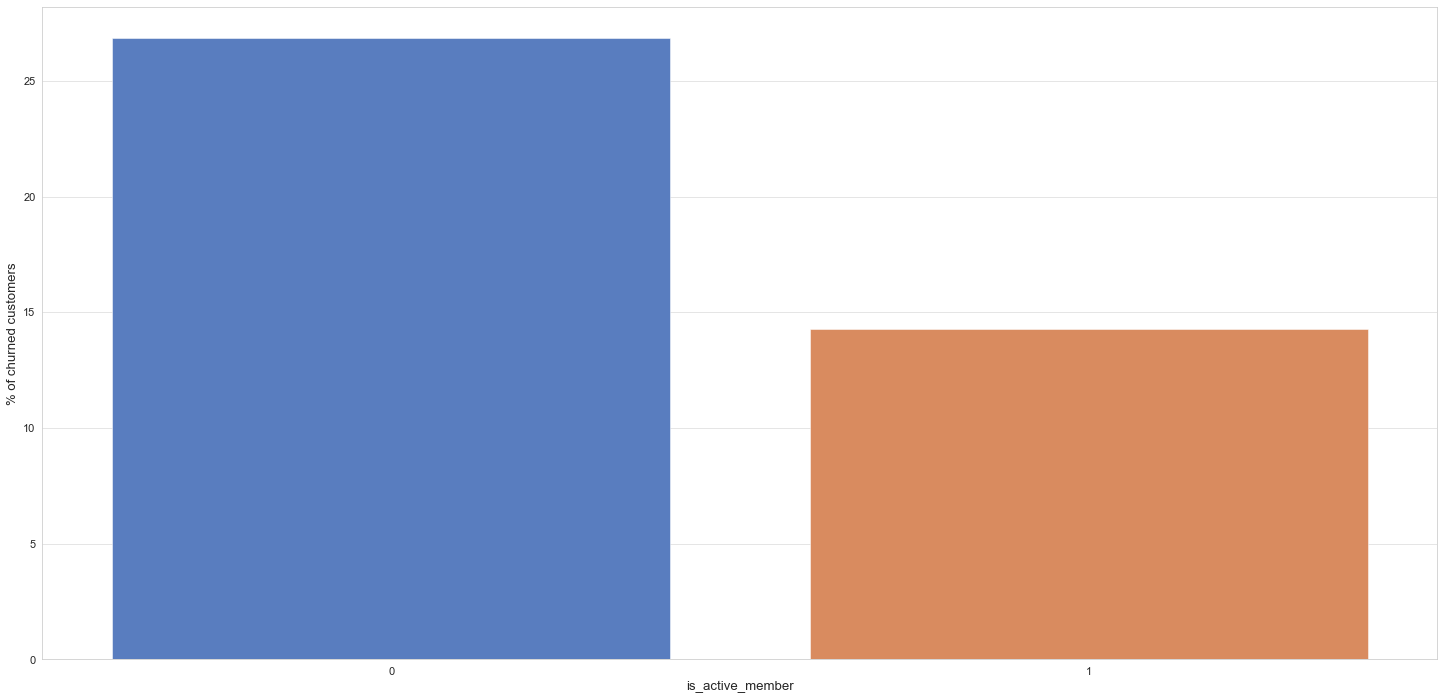

In [34]:
df_aux = df5[['is_active_member', 'exited']].groupby( 'is_active_member' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='is_active_member', y='% of churned customers', data=df_aux);

### H9. German customers are more likely to churn.
* **TRUE** - There is a difference greater than 10% between the churn rate from Germans and the others.

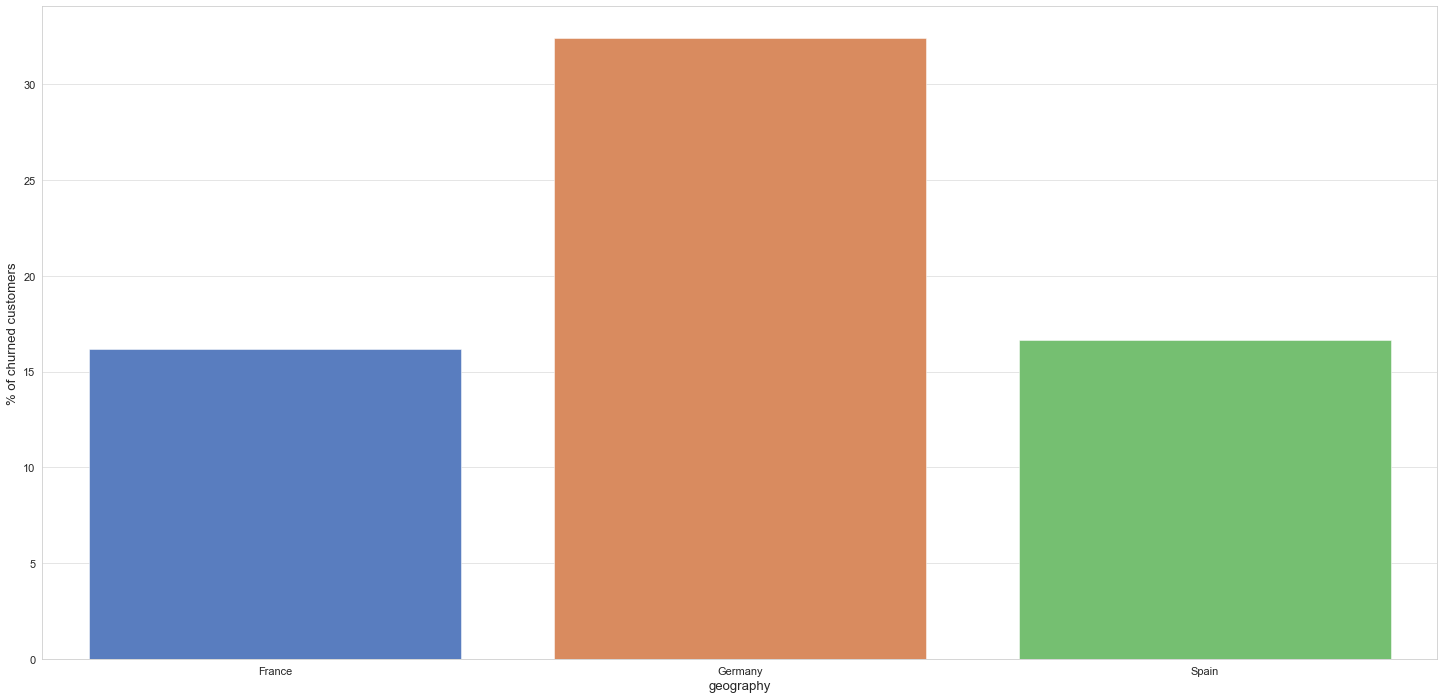

In [35]:
df_aux = df5[['geography', 'exited']].groupby( 'geography' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='geography', y='% of churned customers', data=df_aux);

### H10. Male customers are more likely to churn.
* **FALSE** - Male customers are **less** likely to churn.

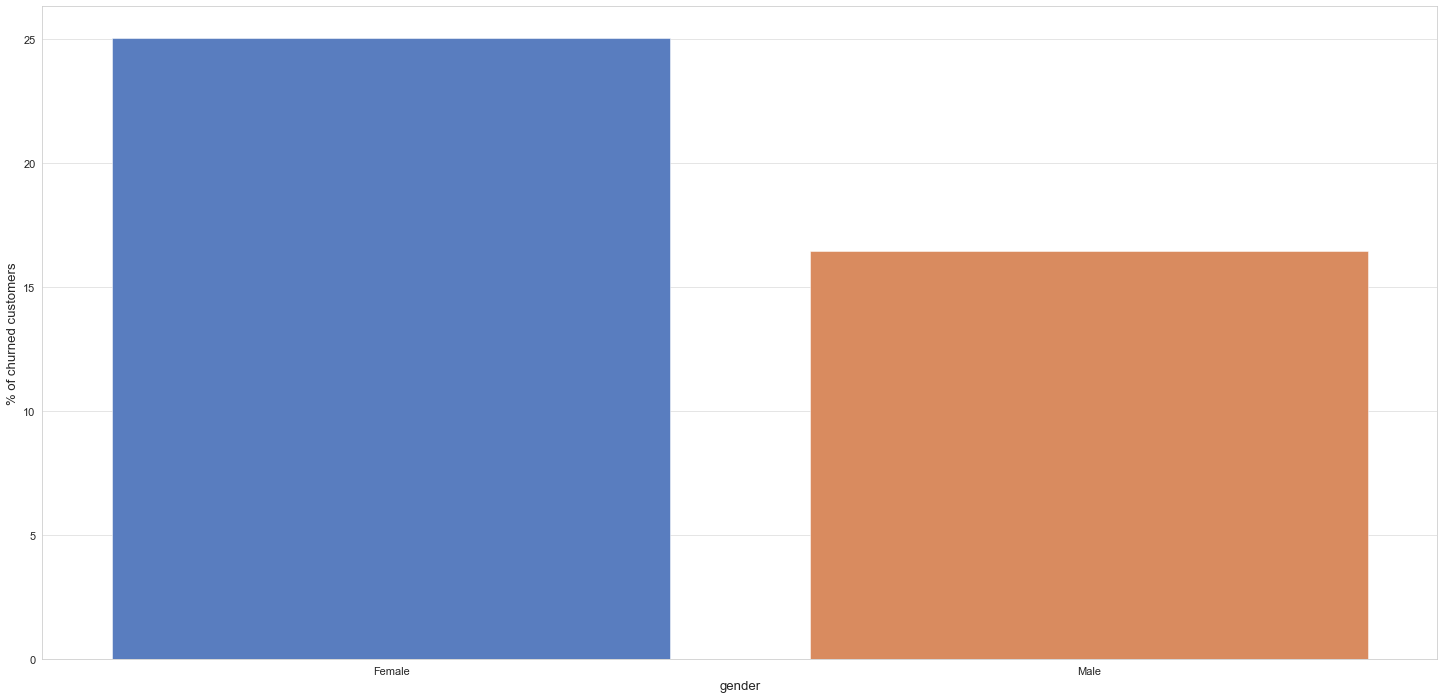

In [36]:
df_aux = df5[['gender', 'exited']].groupby( 'gender' )['exited'].apply( lambda x: x.mean() * 100 ).reset_index()
df_aux.rename( columns={'exited':'% of churned customers'}, inplace=True )

sns.barplot( x='gender', y='% of churned customers', data=df_aux);

## 5.3. Multivariate Analysis

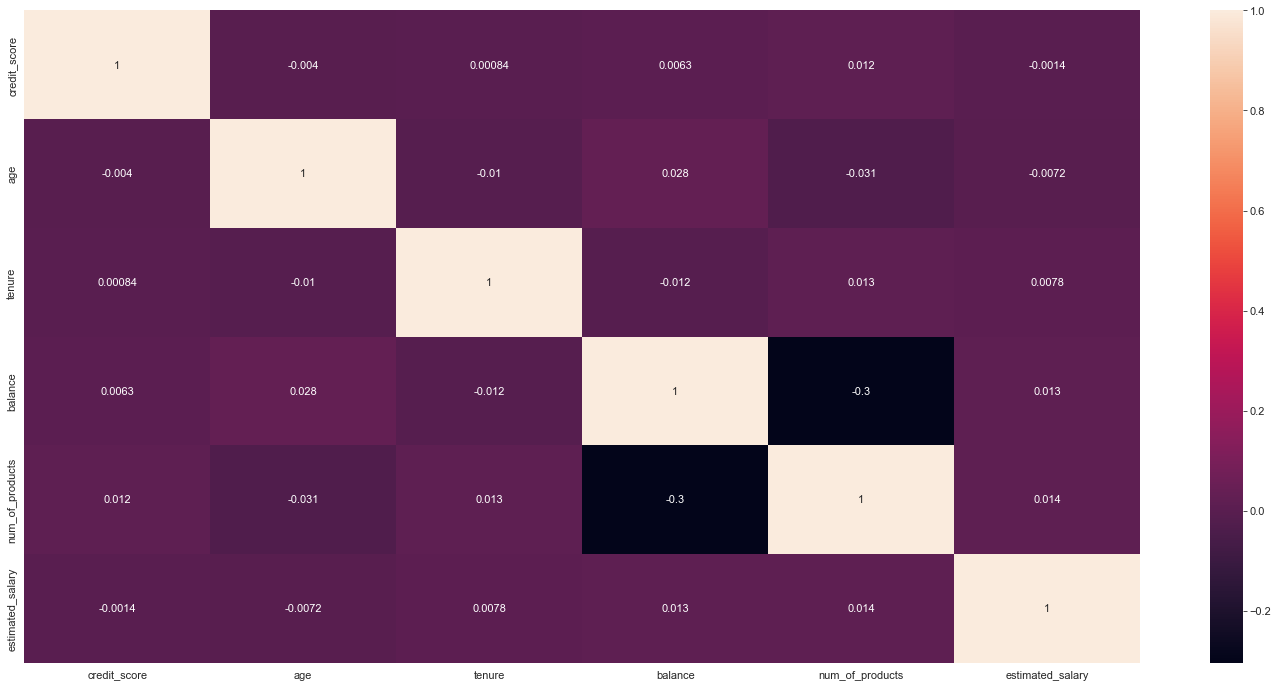

In [37]:
# strength of the correlation between numerical attributes
correlation = num_attrib.drop( columns=['customer_id', 'has_cr_card', 'is_active_member', 'exited'] ).corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

# 6. Data Preparation

In [38]:
df6 = df5.copy()

## 6.1. Split Dataset

In [39]:
X = df6.drop( columns=['customer_id', 'surname', 'exited'] )
y = df6['exited']

X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42, test_size=0.2  )

In [40]:
ss_balance = StandardScaler()
ss_age = StandardScaler()

X_train['balance'] = ss_balance.fit_transform( X_train[['balance']].values )
X_train['age'] = ss_age.fit_transform( X_train[['age']].values )

## 6.2. Rescaling

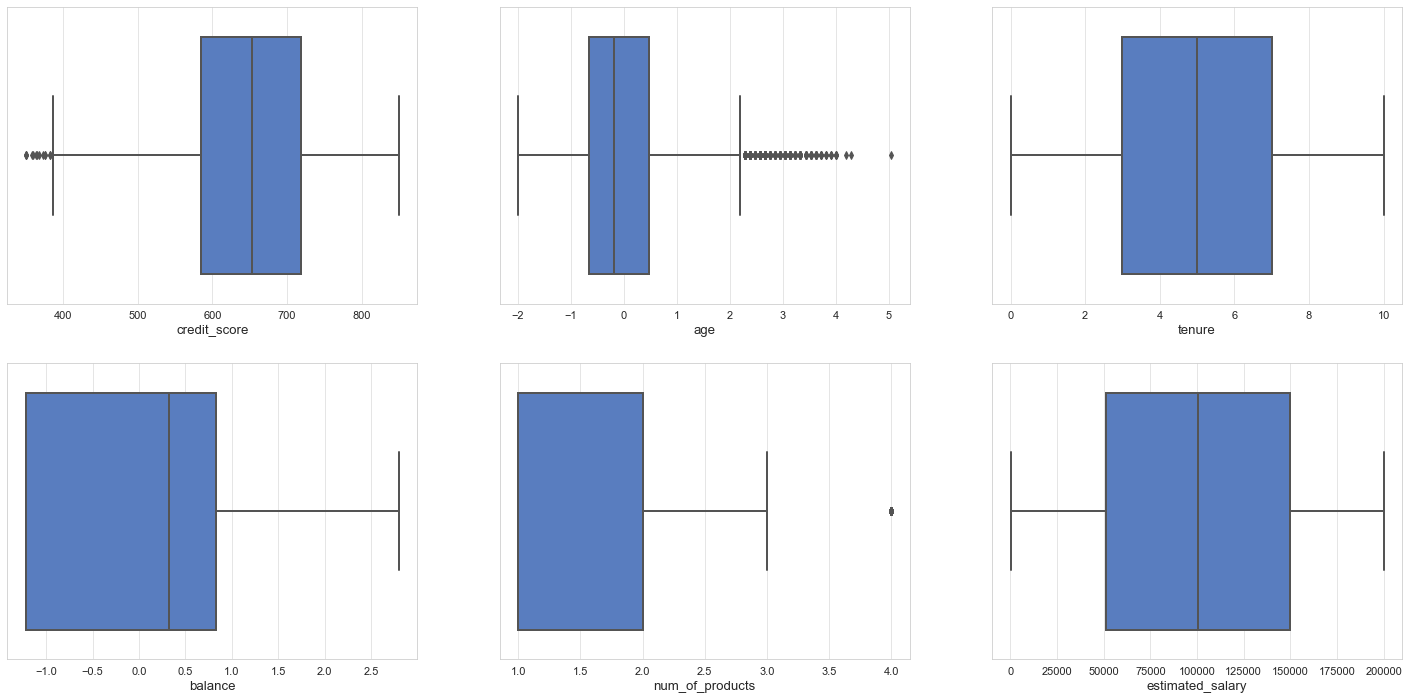

In [41]:
fig, axes = plt.subplots(2,3)

# boxplots for the numerical features
sns.boxplot( x='credit_score', data=X_train, ax=axes[0,0] )
sns.boxplot( x='age', data=X_train, ax=axes[0,1] )
sns.boxplot( x='tenure', data=X_train, ax=axes[0,2] )
sns.boxplot( x='balance', data=X_train, ax=axes[1,0] )
sns.boxplot( x='num_of_products', data=X_train, ax=axes[1,1] )
sns.boxplot( x='estimated_salary', data=X_train, ax=axes[1,2] );

In [42]:
# MinMaxScaler
ms_tenure = MinMaxScaler()
ms_balance = MinMaxScaler()
ms_estSalary = MinMaxScaler()

X_train['tenure'] = ms_tenure.fit_transform( X_train[['tenure']].values )
#X_train['balance'] = ms_balance.fit_transform( X_train[['balance']].values )
X_train['estimated_salary'] = ms_estSalary.fit_transform( X_train[['estimated_salary']].values )


# RobustScaler
rs_age = RobustScaler()
rs_creditScore = RobustScaler()
rs_NumOfProducts = RobustScaler()

#X_train['age'] = rs_age.fit_transform( X_train[['age']].values )
X_train['credit_score'] = rs_creditScore.fit_transform( X_train[['credit_score']].values )
X_train['num_of_products'] = rs_NumOfProducts.fit_transform( X_train[['num_of_products']].values )

In [43]:
# transform test data
X_test['tenure'] = ms_tenure.transform( X_test[['tenure']].values )
#X_test['balance'] = ms_balance.transform( X_test[['balance']].values )
X_test['balance'] = ss_balance.transform( X_test[['balance']].values )
X_test['estimated_salary'] = ms_estSalary.transform( X_test[['estimated_salary']].values )
#X_test['age'] = rs_age.transform( X_test[['age']].values )
X_test['age'] = ss_age.transform( X_test[['age']].values )
X_test['credit_score'] = rs_creditScore.transform( X_test[['credit_score']].values )
X_test['num_of_products'] = rs_NumOfProducts.transform( X_test[['num_of_products']].values )

## 6.3. Transformation

### 6.3.1. Encoding

In [44]:
# One Hot Encoding
X_train = pd.get_dummies(X_train, prefix=['geography'], columns=['geography'] )

# Label Encoding
Gender_dict = {'Male': 0, 'Female': 1}
X_train['gender'] = X_train['gender'].map(Gender_dict)
X_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
9254,0.246269,0,-0.655786,0.6,-1.218471,1.0,1,1,0.895550,1,0,0
1561,-0.156716,0,0.294938,0.4,0.696838,1.0,1,1,0.980029,0,1,0
1670,-0.701493,0,-1.416365,0.3,0.618629,0.0,1,0,0.429261,0,0,1
6087,-0.686567,1,-1.131148,0.9,0.953212,0.0,1,0,0.765408,1,0,0
6669,-1.014925,0,1.625953,0.9,1.057449,0.0,0,0,0.197107,1,0,0


In [45]:
# transform test data
X_test = pd.get_dummies(X_test, prefix=['geography'], columns=['geography'] )
X_test['gender'] = X_test['gender'].map(Gender_dict)

## 6.4. Data Sampling

In [46]:
sample_method = SMOTETomek( smote=SMOTENC(categorical_features=[1, 5, 6, 7, 9, 10, 11]), tomek=TomekLinks(sampling_strategy='majority'), random_state=42)

X_train_bal, y_train_bal = sample_method.fit_sample(X_train, y_train)

In [47]:
np.bincount(y_train_bal)

array([6129, 6356], dtype=int64)

# 7. Feature Selection

In [48]:
df7 = df6.copy()

## 7.1. Boruta

In [49]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1 )

# define Boruta (Activate to run Boruta)
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 0, random_state = 42 ).fit( X_train_n, y_train_n )

In [50]:
##(Activate after run Boruta)
cols_selected = boruta.support_.tolist()

## best features
X_train_fs = X_train.copy() 
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age', 'balance', 'num_of_products', 'estimated_salary']

## 7.2. Manual Feature Selection

* Most Important Features:
    * From the EDA:
        - **age**
        - gender
        - geography (Germany)
        - **credit_score**
        - **num_of_products**
        - **is_active_member**
    * From Boruta:
        - **credit_score**
        - **age**
        - tenure
        - balance
        - **num_of_products**
        - **is_active_member**
        - estimated_salary

In [51]:
X_train.columns

Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'geography_France', 'geography_Germany', 'geography_Spain'],
      dtype='object')

In [52]:
final_cols_selected = X_train.columns #['credit_score','age','num_of_products','is_active_member', 'gender', 'geography_Germany']

# 8. Machine Learning Model

In [53]:
x_train_bal = X_train_bal[ final_cols_selected ]
x_test = X_test[ final_cols_selected ]

## 8.1. Logistic Regression

In [116]:
# model
lr_model = LogisticRegression( random_state=42 ).fit( x_train_bal, y_train_bal )

# prediction
y_pred_lr = lr_model.predict( x_test )

# performance
lr_result = ml_metrics( 'Logistic Regression', y_test, y_pred_lr )
lr_result

,Model Name,Accuracy,Recall,F1 Score
0,Logistic Regression,0.7295,0.687023,0.499537


### 8.1.1. Cross-validation

In [117]:
lr_result_cv = cross_val(X, y, "Logistic Regression", lr_model, kfold=10)
lr_result_cv

,Model Name,Accuracy CV,Recall CV,F1 Score CV
0,Logistic Regression,0.72 +/- 0.01,0.66 +/- 0.02,0.49 +/- 0.02


### 8.1.2. Plot Curves

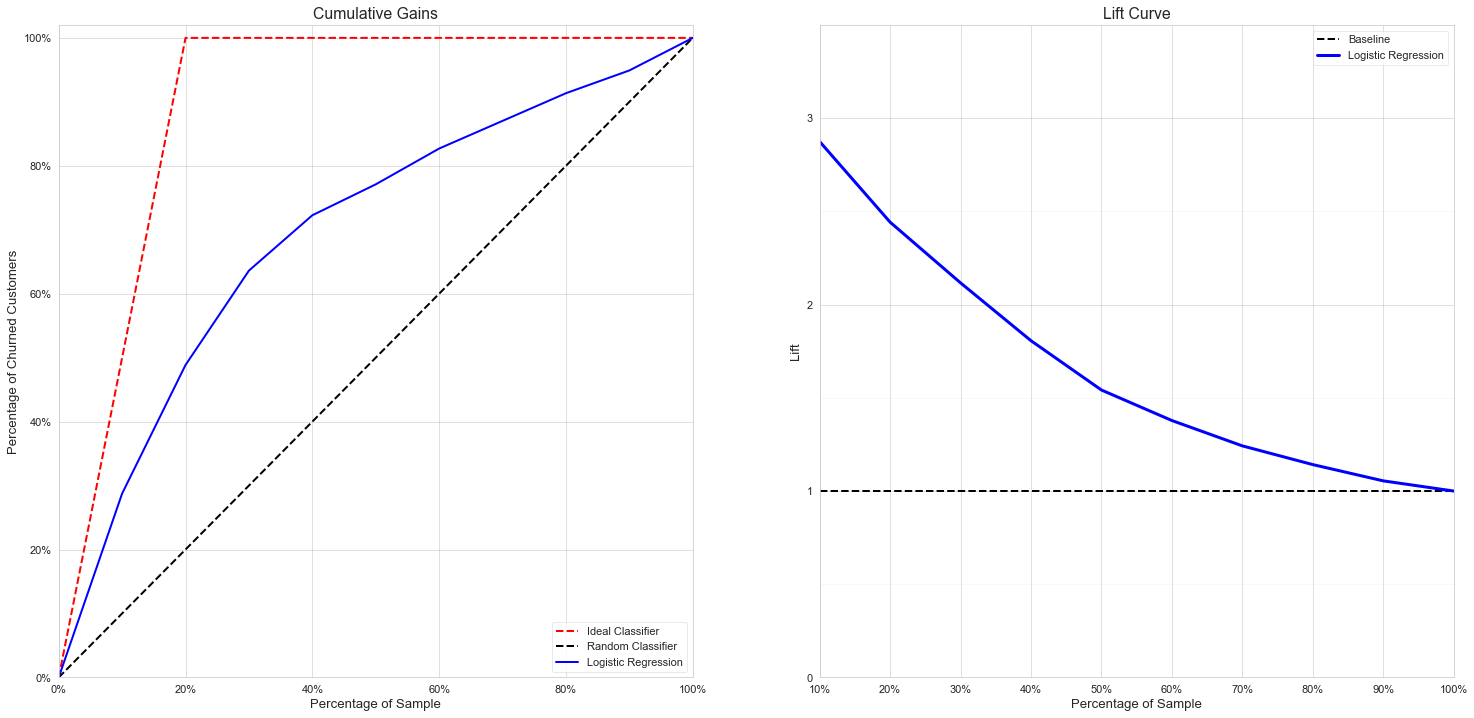

In [118]:
# plot cumulative gain curve and lift curve
lr_lifts, lr_gains = get_lift_gain(lr_model, x_test, y_test)  
plot_lift_gain_curves([lr_gains], [lr_lifts], ['Logistic Regression'], churn_ratio=0.2, step=0.1)

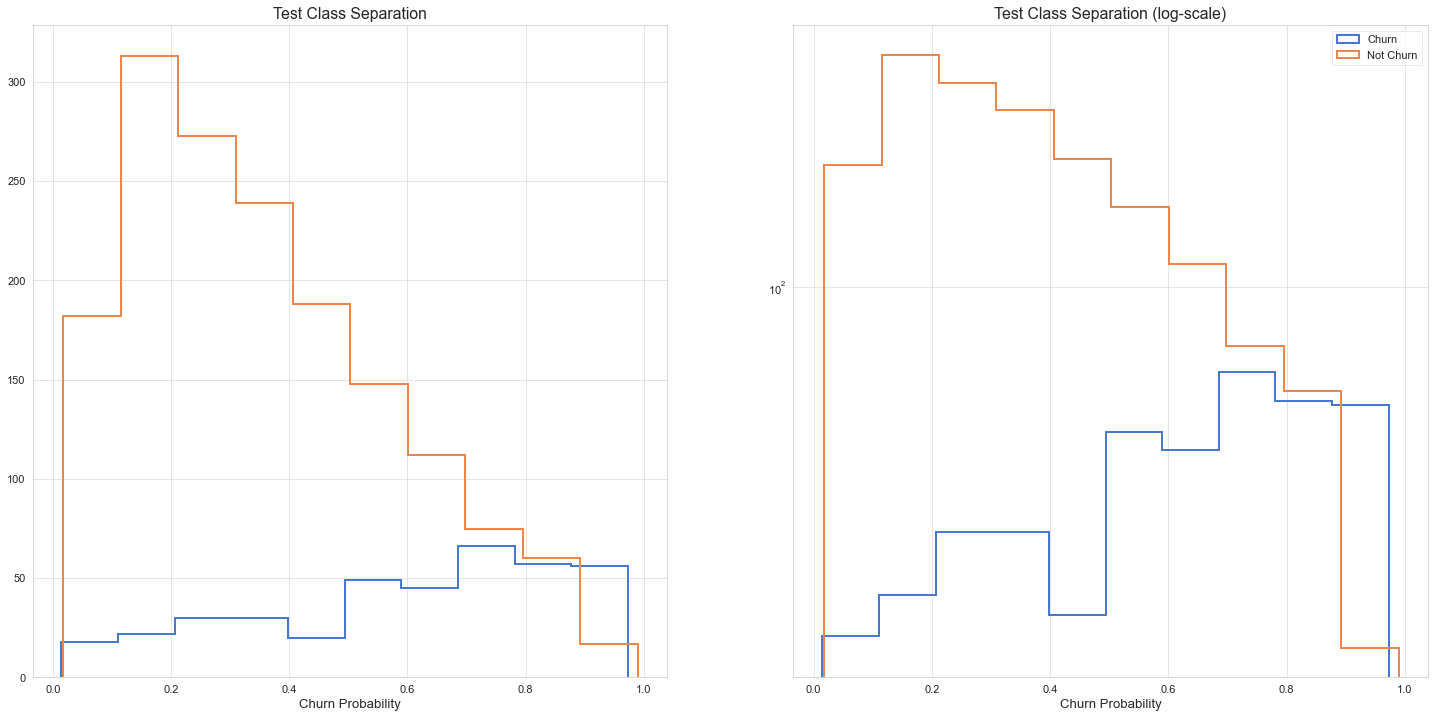

In [119]:
plot_separation(lr_model, x_test, y_test, 'Test Class')

## 8.2. Random Forest Classifier

In [120]:
# model
rf_model = RandomForestClassifier( random_state=42 ).fit( x_train_bal, y_train_bal )

# prediction
y_pred_rf = rf_model.predict( x_test )

# performance
rf_result = ml_metrics( 'Random Forest Classifier', y_test, y_pred_rf )
rf_result

,Model Name,Accuracy,Recall,F1 Score
0,Random Forest Classifier,0.8285,0.64631,0.596945


### 8.2.1. Cross-validation

In [121]:
rf_result_cv = cross_val(X, y, "Random Forest Classifier", rf_model, kfold=10)
rf_result_cv

,Model Name,Accuracy CV,Recall CV,F1 Score CV
0,Random Forest Classifier,0.83 +/- 0.01,0.63 +/- 0.04,0.6 +/- 0.02


### 8.2.2. Plot Curves

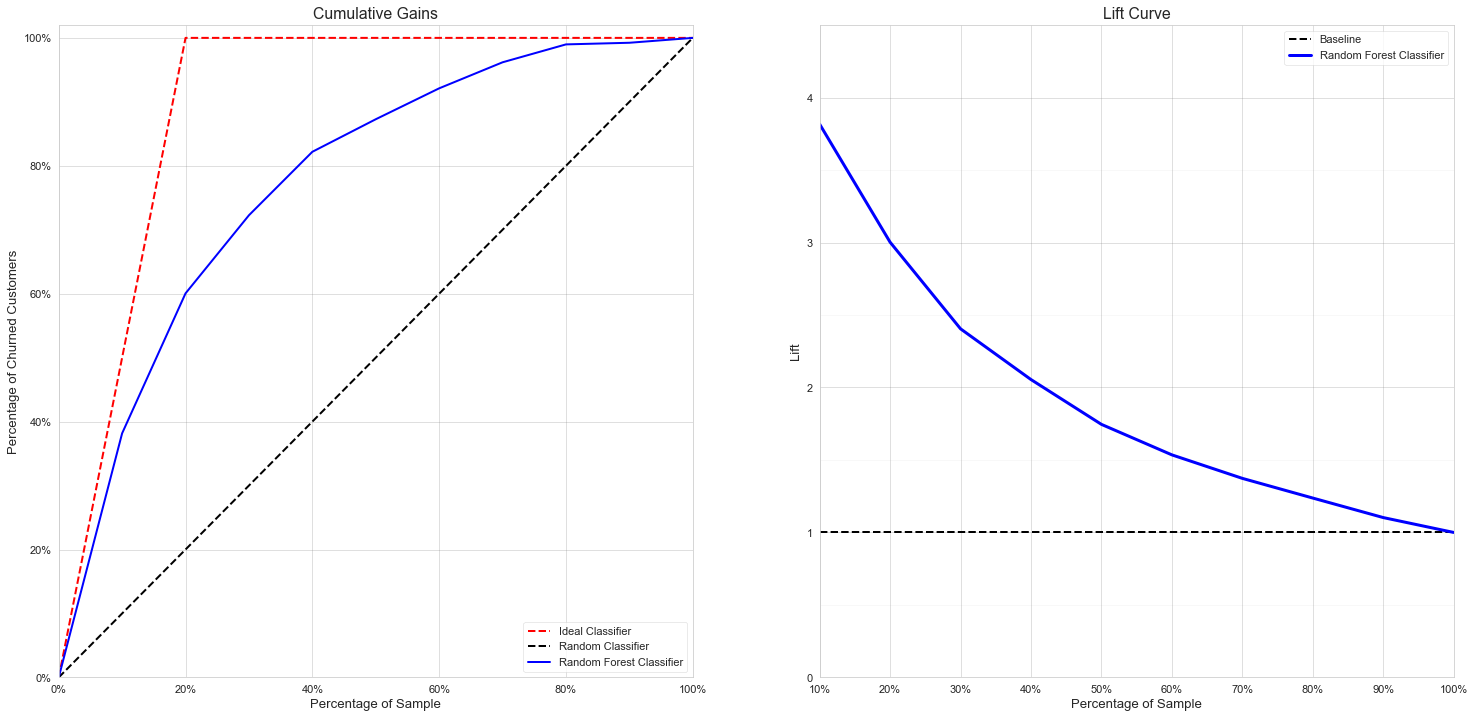

In [122]:
# plot cumulative gain curve and lift curve
rf_lifts, rf_gains = get_lift_gain(rf_model, x_test, y_test)  
plot_lift_gain_curves([rf_gains], [rf_lifts], ['Random Forest Classifier'], churn_ratio=0.2, step=0.1)

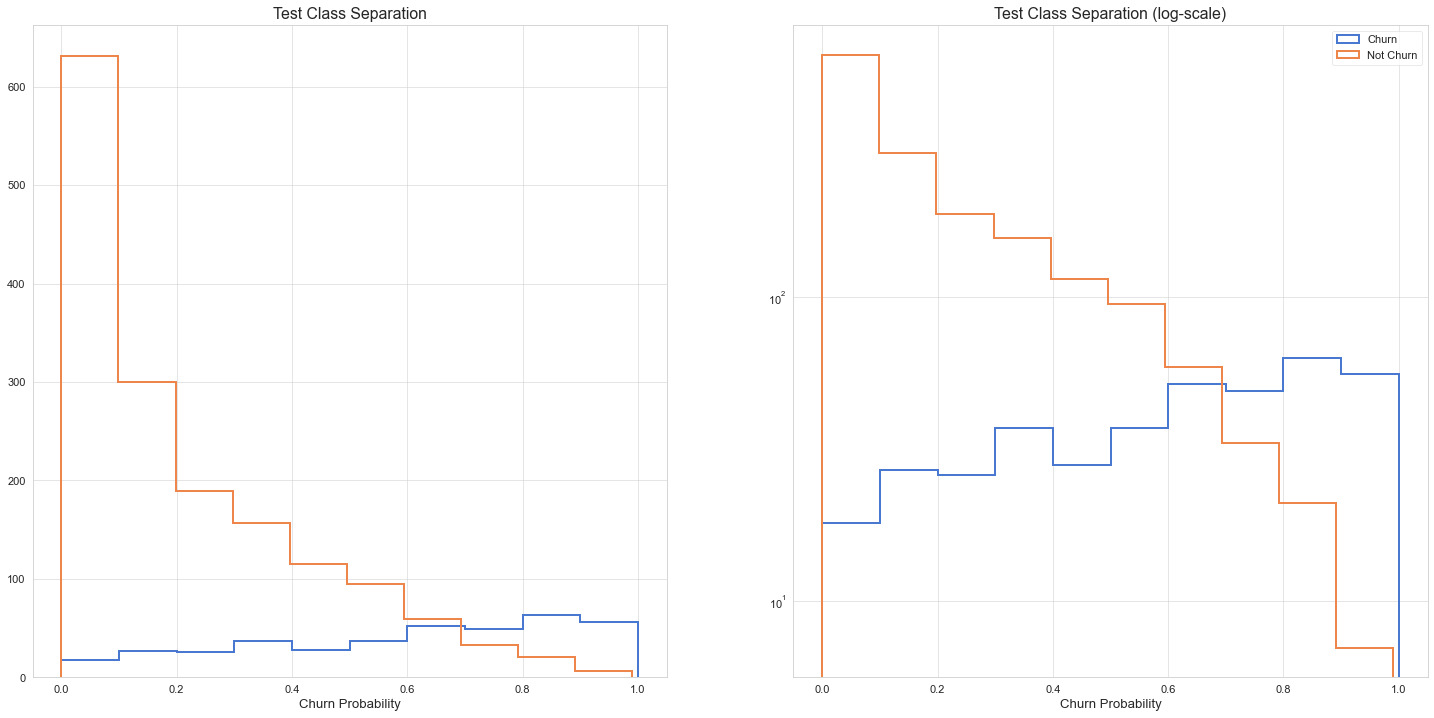

In [123]:
plot_separation(rf_model, x_test, y_test, 'Test Class')

## 8.3. XGBoost Classifier

In [141]:
# model
xgb_model = XGBClassifier( random_state=42, eval_metric='logloss', n_jobs=-1 ).fit( x_train_bal, y_train_bal )

# prediction
y_pred_xgb = xgb_model.predict( x_test )

# performance
xgb_result = ml_metrics( 'XGBoost Classifier', y_test, y_pred_xgb )
xgb_result

,Model Name,Accuracy,Recall,F1 Score
0,XGBoost Classifier,0.856,0.569975,0.608696


### 8.3.1. Cross-validation

In [142]:
xgb_result_cv = cross_val(X, y, "XGBoost Classifier", xgb_model, kfold=10)
xgb_result_cv

,Model Name,Accuracy CV,Recall CV,F1 Score CV
0,XGBoost Classifier,0.85 +/- 0.01,0.56 +/- 0.04,0.6 +/- 0.02


### 8.3.2. Plot Curves

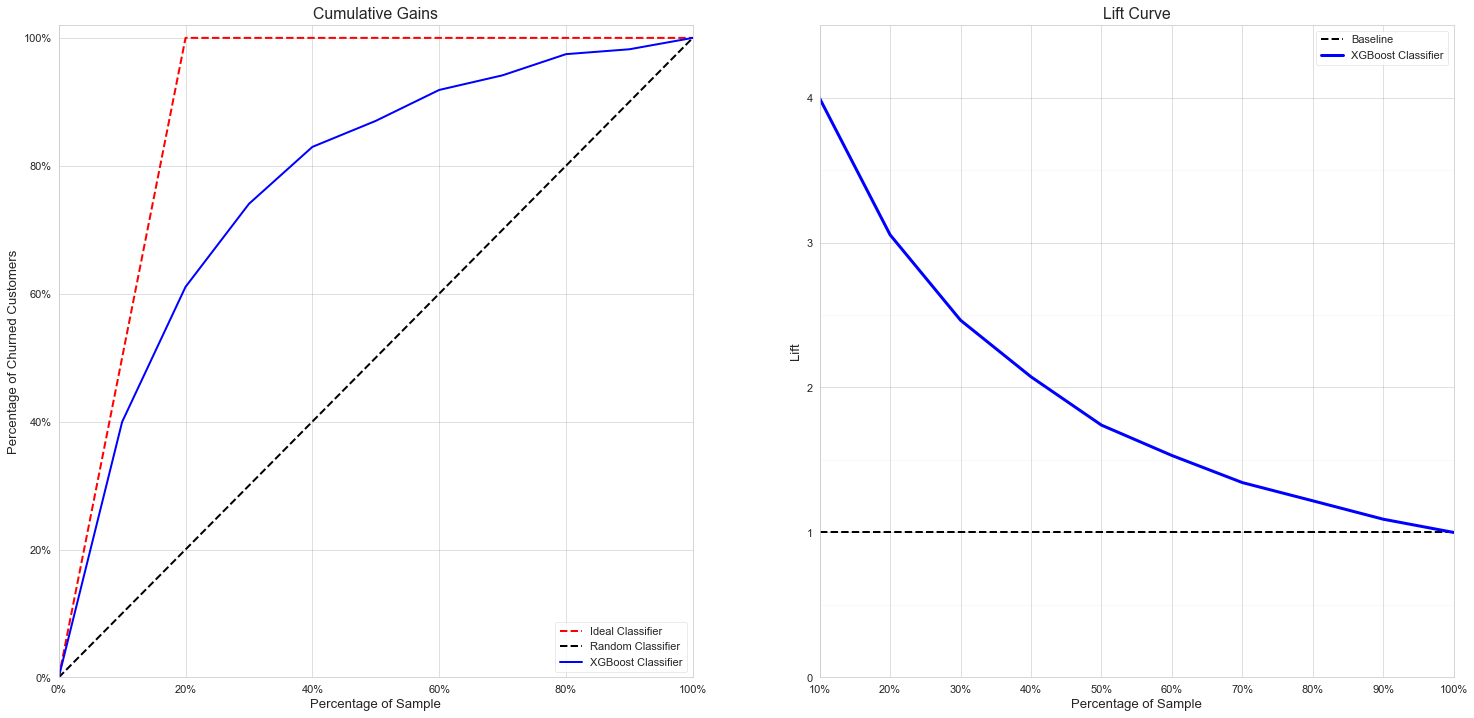

In [143]:
# plot cumulative gain curve and lift curve
xgb_lifts, xgb_gains = get_lift_gain(xgb_model, x_test, y_test)  
plot_lift_gain_curves([xgb_gains], [xgb_lifts], ['XGBoost Classifier'], churn_ratio=0.2, step=0.1)

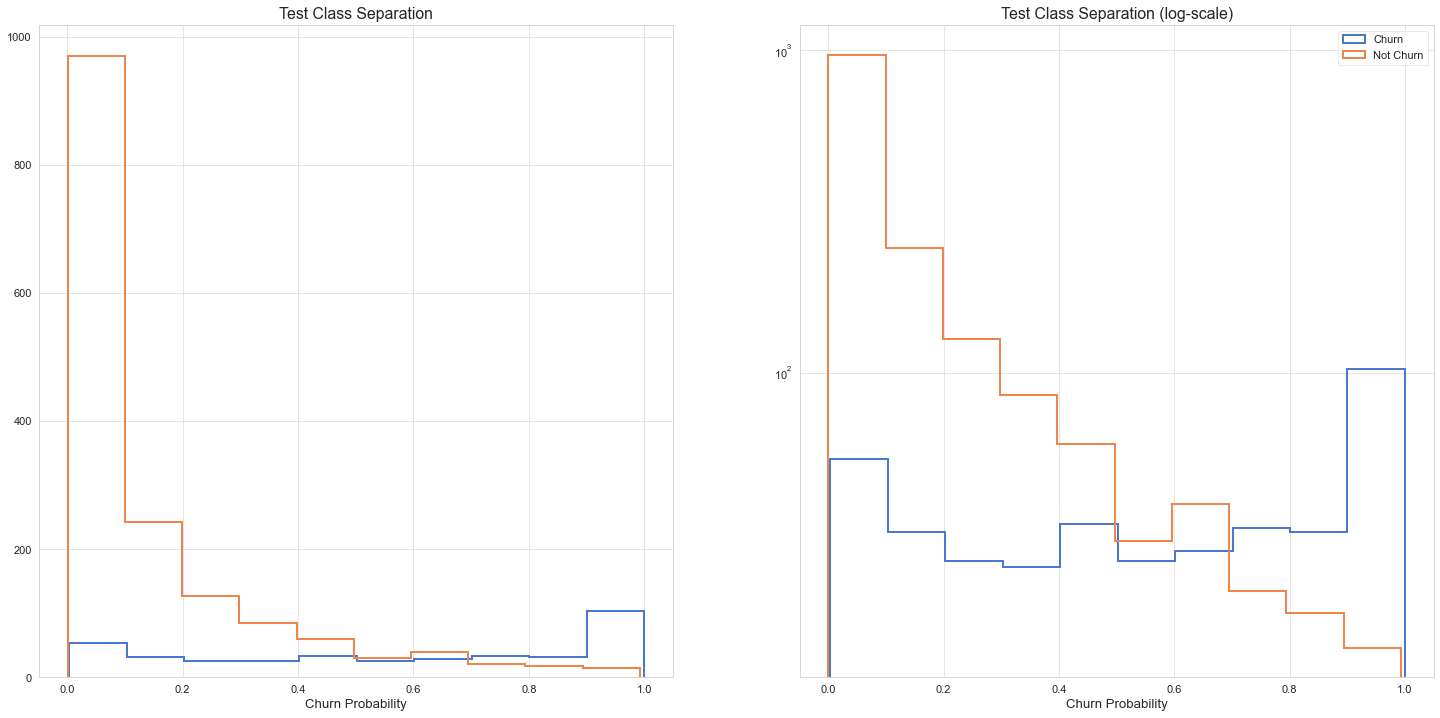

In [127]:
plot_separation(xgb_model, x_test, y_test, 'Test Class')

## 8.3. Compare Model's Performance

In [128]:
modelling_result = pd.concat( [lr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result

,Model Name,Accuracy CV,Recall CV,F1 Score CV
0,Logistic Regression,0.72 +/- 0.01,0.66 +/- 0.02,0.49 +/- 0.02
0,Random Forest Classifier,0.83 +/- 0.01,0.63 +/- 0.04,0.6 +/- 0.02
0,XGBoost Classifier,0.85 +/- 0.01,0.56 +/- 0.04,0.6 +/- 0.02


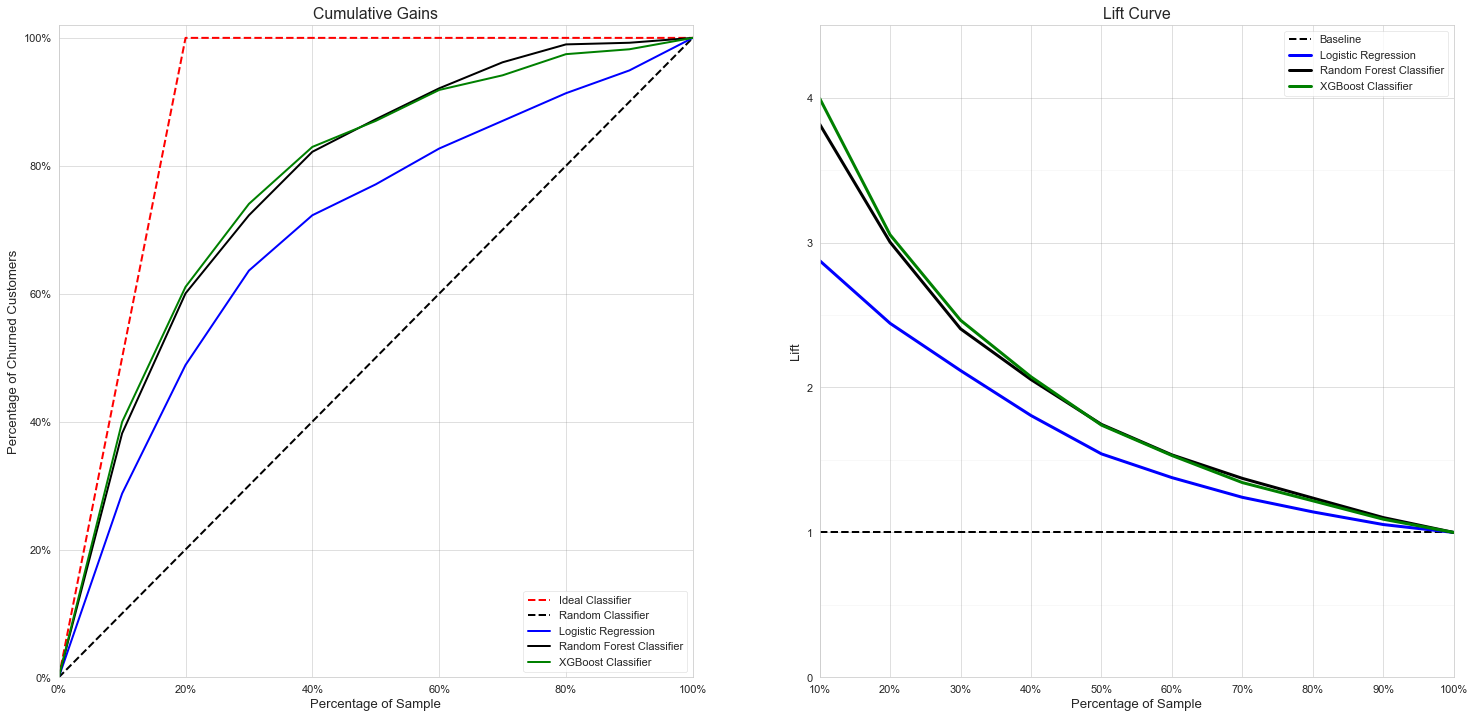

In [146]:
plot_lift_gain_curves([lr_gains, rf_gains, xgb_gains], [lr_lifts, rf_lifts, xgb_lifts], ['Logistic Regression', 'Random Forest Classifier', 'XGBoost Classifier'], churn_ratio=0.2, step=0.1)

# 9. Hyperparameter Fine Tuning

In [163]:
def func_min(params):
    
    model = XGBClassifier(   
                            n_estimators=params[0],
                            eta=params[1],
                            max_depth=params[2],
                            subsample=params[3],
                            colsample_bytree=params[4],
                            min_child_weight=params[5],

                            random_state=42, 
                            eval_metric='logloss',
                            n_jobs=-1
                        
                         ).fit( x_train_bal, y_train_bal )
    
    lift_list, gain_list = get_lift_gain(model, x_test, y_test, 0.1)
    
    return 1 - gain_list[2]

In [151]:
from skopt import forest_minimize, gp_minimize

In [157]:
space = [
    (1000, 5000),
    (1e-3, 1e-1, 'log-uniform'),
    (3, 20),
    (0.05, 1.),
    (0.05, 1.),
    (3, 20)
]

'''{
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}'''

res = gp_minimize( func_min, space, random_state=42, n_random_starts=20, n_calls=50, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 48.9669
Function value obtained: 0.5929
Current minimum: 0.5929
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.7690
Function value obtained: 0.6183
Current minimum: 0.5929
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 91.2406
Function value obtained: 0.5903
Current minimum: 0.5903
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.8523
Function value obtained: 0.6209
Current minimum: 0.5903
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.3433
Function value obtained: 0.5929
Current minimum: 0.5903
Iteration No: 6 started. Evaluat

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 17.5525
Function value obtained: 0.6081
Current minimum: 0.5903
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 6.0468
Function value obtained: 0.6463
Current minimum: 0.5903
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 11.1664
Function value obtained: 0.6336
Current minimum: 0.5903
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 29.1737
Function value obtained: 0.6081
Current minimum: 0.5903
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 35.1774
Function value obtained: 0.6412
Current minimum: 0.5903
Iteration No: 47 started.

In [153]:
res.x

[3721, 0.007961566078062952, 3, 0.9450916679006104, 0.5851238069532625, 10]

## 9.1. Final Model

In [164]:
opt_params = [3721, 0.007961566078062952, 3, 0.9450916679006104, 0.5851238069532625, 10]

# model
xgb_model_opt = XGBClassifier( n_estimators=opt_params[0],
                            eta=opt_params[1],
                            max_depth=opt_params[2],
                            subsample=opt_params[3],
                            colsample_bytree=opt_params[4],
                            min_child_weight=opt_params[5],
                            random_state=42, 
                            eval_metric='logloss',
                            n_jobs=-1
                          ).fit( x_train_bal, y_train_bal )

# prediction
y_pred_xgopt = xgb_model_opt.predict( x_test )

# performance
xgb_result_opt = ml_metrics( 'XGBoost Classifier', y_test, y_pred_xgopt )
xgb_result_opt

,Model Name,Accuracy,Recall,F1 Score
0,XGBoost Classifier,0.8535,0.618321,0.623877


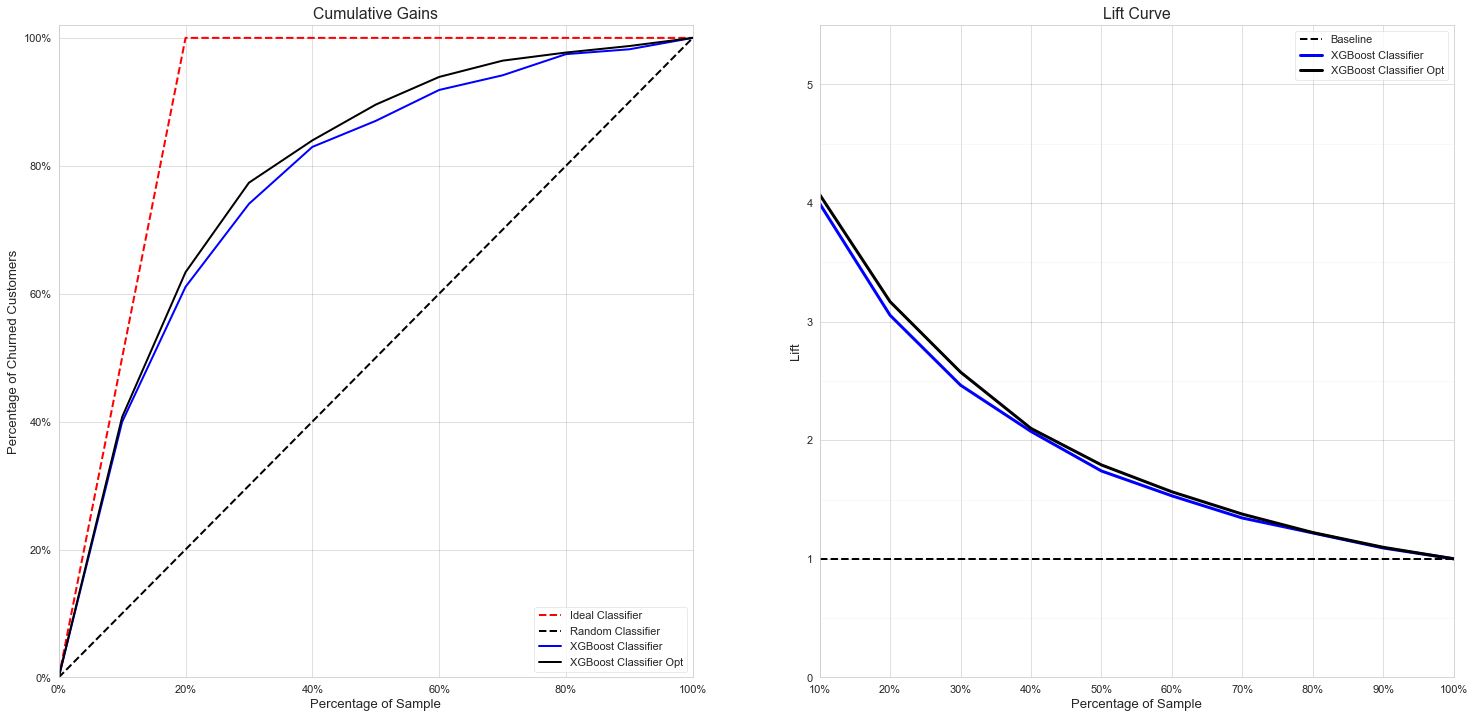

In [165]:
# plot cumulative gain curve and lift curve
xgb_lifts_opt, xgb_gains_opt = get_lift_gain(xgb_model_opt, x_test, y_test)  
plot_lift_gain_curves([xgb_gains, xgb_gains_opt], [xgb_lifts, xgb_lifts_opt], ['XGBoost Classifier', 'XGBoost Classifier Opt'], churn_ratio=0.2, step=0.1)